<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
import scipy.io
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set()

In [3]:
!pip install -q pymer4

     |████████████████████████████████| 59 kB 2.9 MB/s 


In [4]:
from pymer4.models import Lmer

In [5]:
!pip install -q statsmodels

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [44]:
# Install R and Rpy2
!apt-get install r-base
!pip install -q rpy2

# Install LMER packages (THIS TAKES ABOUT 3~5 minutes)
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.2.0-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f02980219b0> [RTYPES.NILSXP]

In [8]:
%load_ext rpy2.ipython

In [45]:
%%R 
library(lme4)
library(lmerTest)

## Uploading data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
working_path = Path('/content/drive/MyDrive/CoganLab')

IEEG dataset: ['D30', 'D33', 'D49', 'D54', 'D61', 'D65', 'D70'] this subjects are below 75% threshold. 213 No response trials (according to 'Resp' column). Column 'Out' contains infor on whether it is outlier or not. 

In [12]:
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_subset.csv'),
    index_col=None
)

EEG dataset without outliers but with 'no response' trials. Non of the subjects was rejected because all of them are above 75% accuracy.

In [13]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_no_outliers.csv'),
    index_col=None
)

In [14]:
ieeg = ieeg.loc[:, ieeg.columns != 'Unnamed: 0']
eeg = eeg.loc[:, eeg.columns != 'Unnamed: 0']

## Plots EEG dataset w/out No Response trials

BOTH MATCH AND MISMATCH: all conditions, W vs NW, H vs L

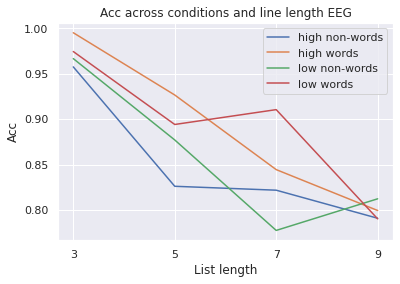

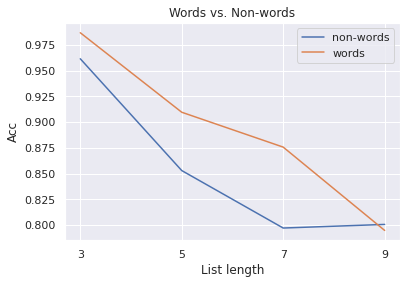

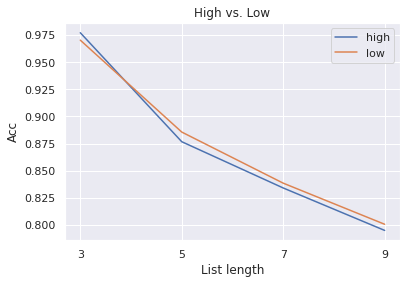

In [15]:
eeg_subset = eeg[eeg['Response'] != 'No Response']

pl.figure()
subset = eeg_subset.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG');

pl.figure()
subset = eeg_subset.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words');

pl.figure()
subset = eeg_subset.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low');

ONLY MATCH: all cond's, W vs NW, H vs L

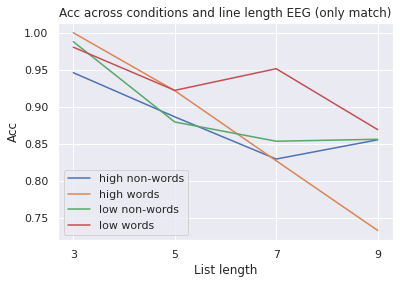

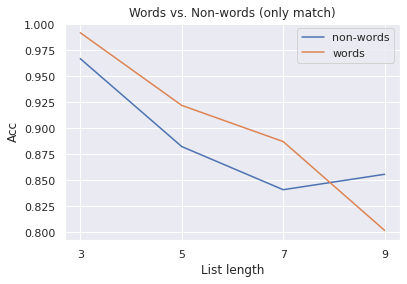

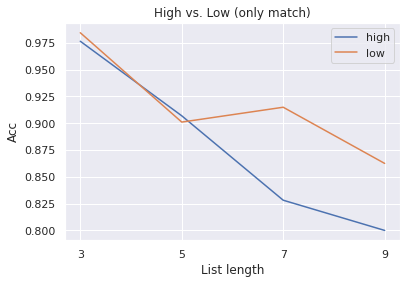

In [28]:
only_match = eeg_subset[eeg_subset['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only match)');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.ResponseCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.ResponseCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match)');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match)');

ONLY MISMATCH: all cond's, W vs NW, H vs L

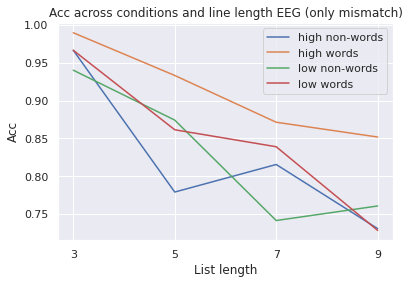

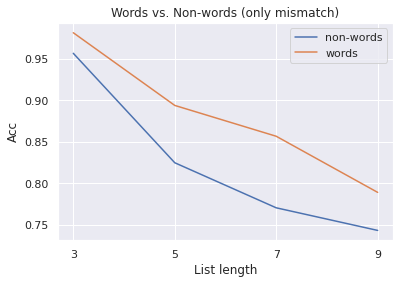

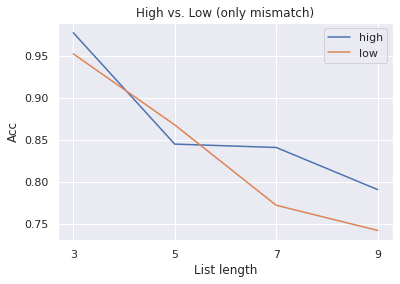

In [33]:
only_mismatch = eeg_subset[eeg_subset['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch)');

Plotting match vs mismatch on the same plot

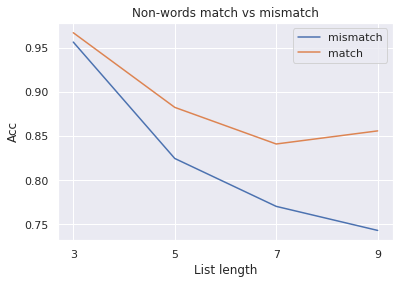

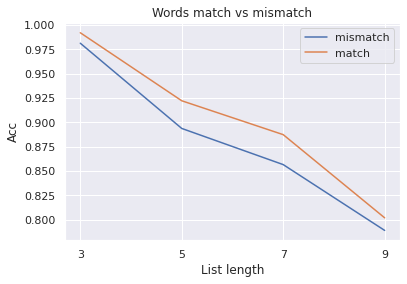

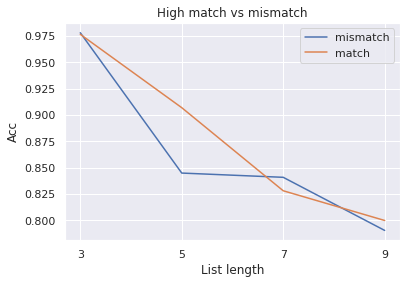

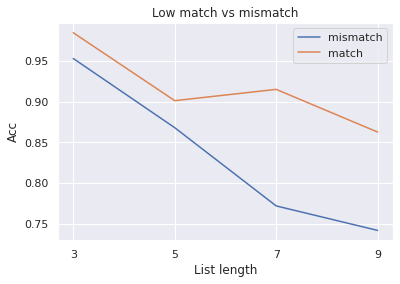

In [38]:
pl.figure()
nonwords = eeg_subset[eeg_subset['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch');

pl.figure()
words = eeg_subset[eeg_subset['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch');

pl.figure()
high = eeg_subset[eeg_subset['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch');

pl.figure()
low = eeg_subset[eeg_subset['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch');

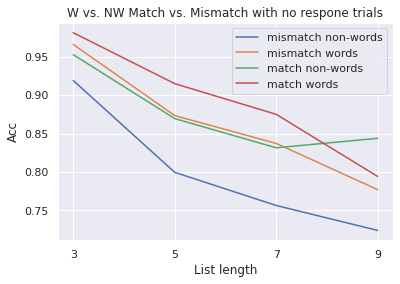

In [198]:
pl.figure()
subset = eeg.groupby(['ProbeType', 'Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  for j in subset.Lex.unique():
    x = subset[(subset['ProbeType'] == i) & (subset['Lex'] == j)]
    if i == 1:
      name1 = 'mismatch'
      if j == 0:
        name2 = 'non-words'
      elif j == 1:
        name2 = 'words'
    elif i == 2:
      name1 = 'match'
      if j == 0:
        name2 = 'non-words'
      elif j == 1:
        name2 = 'words'
    pl.plot(x.Length, x.ResponseCorrect, label = (name1 + ' ' + name2))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('W vs. NW Match vs. Mismatch with no respone trials');

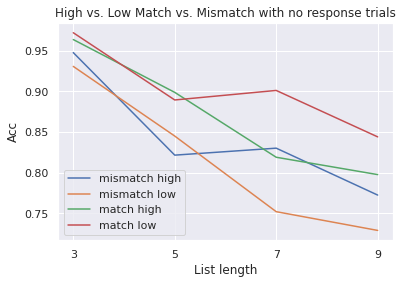

In [197]:
pl.figure()
subset = eeg.groupby(['ProbeType', 'Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  for j in subset.Phono.unique():
    x = subset[(subset['ProbeType'] == i) & (subset['Phono'] == j)]
    if i == 1:
      name1 = 'mismatch'
      if j == 0:
        name2 = 'high'
      elif j == 1:
        name2 = 'low'
    elif i == 2:
      name1 = 'match'
      if j == 0:
        name2 = 'high'
      elif j == 1:
        name2 = 'low'
    pl.plot(x.Length, x.ResponseCorrect, label = (name1 + ' ' + name2))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low Match vs. Mismatch with no response trials');

##Plots EEG with 'No response trials' as incorrect

1.   100 'No response' trials
2.   No subjects less than 75% accurate
3.   The max of no response trials - 10% of all trials



In [ ]:
eeg[eeg['Response'] == 'No Response'].groupby(['Subject'])[['Trial']].count()

In [70]:
eeg[eeg['Response'] == 'No Response'].groupby(['ProbeCategory'])[['Trial']].count()

,Trial
ProbeCategory,
high non-words,28
high words,20
low non-words,32
low words,20


BOTH MATCH AND MISMATCH

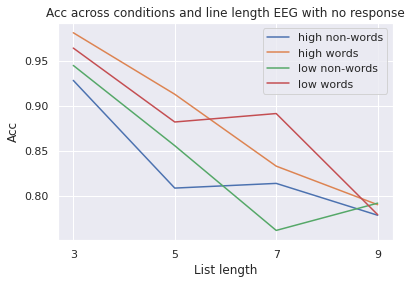

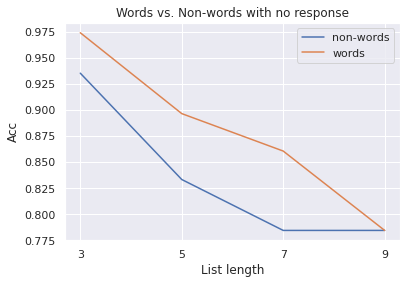

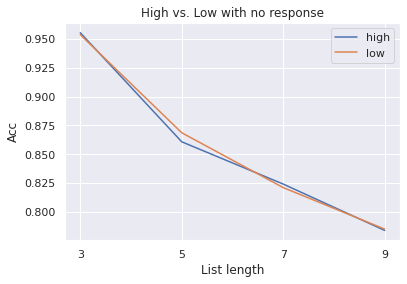

In [78]:
pl.figure()
subset = eeg.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG with no response');

pl.figure()
subset = eeg.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words with no response');

pl.figure()
subset = eeg.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low with no response');

ONLY MATCH

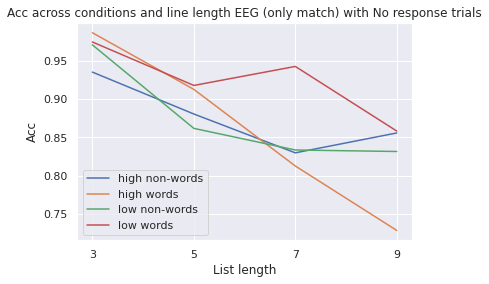

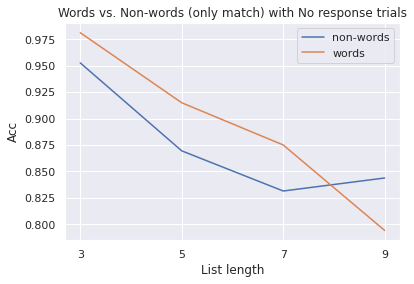

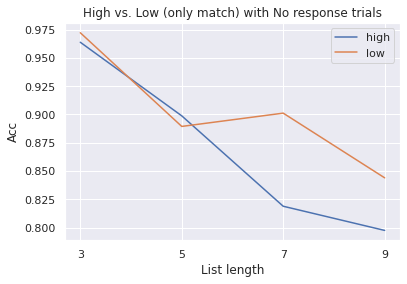

In [76]:
only_match = eeg[eeg['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.ResponseCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.ResponseCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match) with No response trials');

ONLY MISMATCH

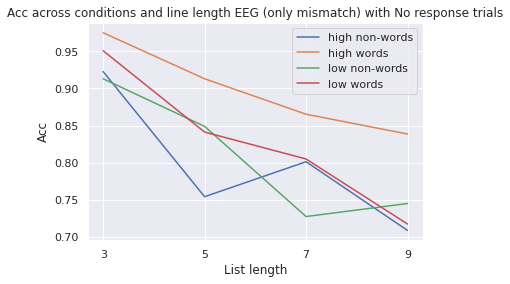

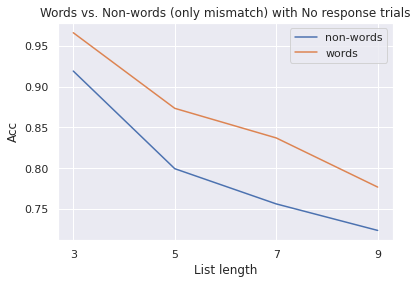

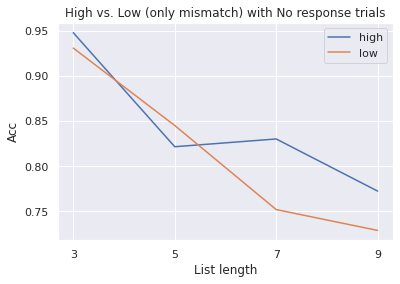

In [75]:
only_mismatch = eeg[eeg['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch) with No response trials');

MATCH AND MISMATCH ON THE SAME PLOT

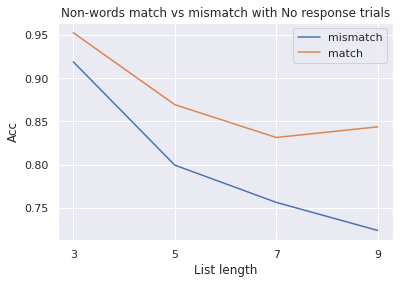

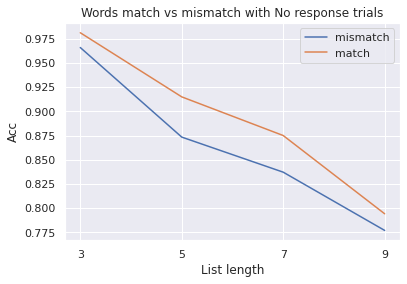

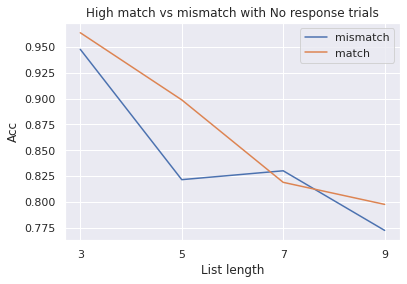

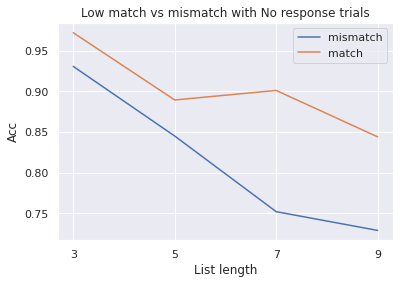

In [74]:
pl.figure()
nonwords = eeg[eeg['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch with No response trials');

pl.figure()
words = eeg[eeg['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch with No response trials');

pl.figure()
high = eeg[eeg['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch with No response trials');

pl.figure()
low = eeg[eeg['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch with No response trials');

## EEG dataset models

In [16]:
eeg_data = eeg[[
                'Trial', 'Subject', 'Block',
                'ProbeType', 'stdRT', 'ResponseCorrect',
                'Position', 'Response', 'Length', 'Lex', 'Phono'
]]

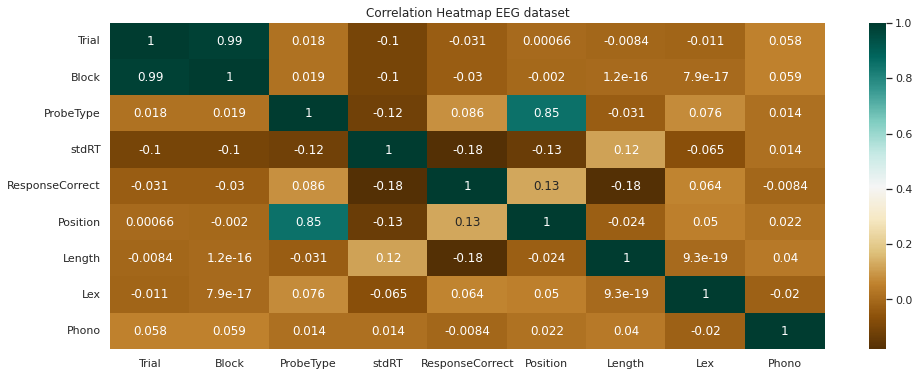

In [17]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(eeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap EEG dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


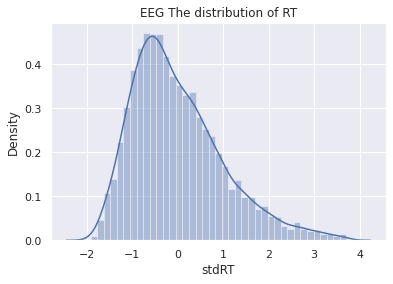

In [19]:
sns.distplot(eeg_data.stdRT)
pl.title('EEG The distribution of RT');

In [18]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

In [187]:
eeg_subset = eeg[eeg['Response'] != 'No Response']
high = eeg[eeg_subset['Phono'] == 0]
low = eeg[eeg_subset['Phono'] == 1]

In [207]:
x, y = low[low['ProbeType'] == 1]['ResponseCorrect'].values, low[low['ProbeType'] == 2]['ResponseCorrect'].values
ttest(x, y)

Ttest_indResult(statistic=-7.112692090412871, pvalue=1.4837511779543144e-12)

In [208]:
for i in low.Length.unique():
  subset = low[low['Length'] == i]
  a = subset[subset['ProbeType'] == 2]['ResponseCorrect'].values
  b = subset[subset['ProbeType'] == 1]['ResponseCorrect'].values
  print(ttest(a,b), i)

Ttest_indResult(statistic=1.7598149984465679, pvalue=0.07888912351127911) 5
Ttest_indResult(statistic=3.676012845863057, pvalue=0.00025638416637370677) 9
Ttest_indResult(statistic=2.273641055643646, pvalue=0.023486894652843857) 3
Ttest_indResult(statistic=5.447939173024526, pvalue=7.104203842824602e-08) 7


In [191]:
for i in mismatch.Length.unique():
  subset = mismatch[mismatch['Length'] == i]
  a = subset[subset['Phono'] == 0]['ResponseCorrect'].values
  b = subset[subset['Phono'] == 1]['ResponseCorrect'].values
  print(ttest(a,b), i)


Ttest_indResult(statistic=2.295681252274476, pvalue=0.021997510580035042) 7
Ttest_indResult(statistic=1.6573690105265337, pvalue=0.09822134201775866) 3
Ttest_indResult(statistic=-0.8310717387483997, pvalue=0.40624402578821606) 5
Ttest_indResult(statistic=1.5376887978558298, pvalue=0.12458317166074365) 9


**Models**

Full model with all IVs: lex, phono, length, probe, position.

In [56]:
null_model = Lmer(
    'ResponseCorrect ~ (1|Subject)',
    data = eeg_data
    )
null_model.fit()

Formula: ResponseCorrect~(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -2044.152 	 AIC: 4088.304

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.043
Residual               0.121  0.348

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.857,0.839,0.875,0.009,28.0,92.361,0.0,***


In [87]:
model1 = Lmer(
    'ResponseCorrect ~ Phono + (1|Subject)', 
    data=eeg_data
    )
model1.fit()

Formula: ResponseCorrect~Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -2047.704 	 AIC: 4095.408

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.043
Residual               0.121  0.348

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.860,0.839,0.880,0.010,42.960,83.257,0.000,***
Phono,-0.006,-0.024,0.012,0.009,5538.336,-0.638,0.523,


In [35]:
model_full = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -1941.963 	 AIC: 3883.927

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.044
Residual               0.116  0.341

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.919,0.877,0.961,0.022,714.845,42.719,0.000,***
Lex,0.040,0.022,0.058,0.009,5535.021,4.412,0.000,***
Phono,-0.001,-0.019,0.017,0.009,5535.321,-0.114,0.909,
Length,-0.027,-0.031,-0.023,0.002,5535.002,-13.345,0.000,***
ProbeType,0.054,0.036,0.072,0.009,5538.844,5.932,0.000,***


In [ ]:
model_full1 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full1.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1557.591 	 AIC: 3115.182

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.103  0.321

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.043,0.952,1.135,0.047,4687.303,22.328,0.000,***
Lex,0.121,0.047,0.195,0.038,5295.857,3.200,0.001,**
Phono,-0.120,-0.194,-0.046,0.038,5296.443,-3.167,0.002,**
Length,-0.039,-0.052,-0.026,0.007,5301.324,-5.767,0.000,***
ProbeType,-0.014,-0.069,0.040,0.028,5301.021,-0.511,0.609,
Lex:Phono,-0.009,-0.043,0.026,0.018,5297.637,-0.487,0.626,
Lex:Length,-0.004,-0.012,0.004,0.004,5295.605,-0.990,0.322,
Lex:ProbeType,-0.041,-0.075,-0.006,0.018,5296.787,-2.322,0.020,*
Phono:Length,0.002,-0.005,0.010,0.004,5298.372,0.623,0.534,
Phono:ProbeType,0.072,0.037,0.106,0.018,5295.726,4.072,0.000,***


In [ ]:
model_full2 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Phono*ProbeType + Lex*Length*ProbeType + Phono*Length*ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full2.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Phono*ProbeType+Lex*Length*ProbeType+Phono*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1560.294 	 AIC: 3120.589

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.102  0.320

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.987,0.854,1.121,0.068,5219.506,14.527,0.000,***
Lex,0.070,-0.097,0.238,0.085,5294.361,0.825,0.409,
Phono,0.180,0.007,0.353,0.088,5293.853,2.039,0.041,*
Length,-0.036,-0.057,-0.015,0.010,5294.441,-3.437,0.001,***
ProbeType,0.017,-0.068,0.102,0.043,5293.520,0.383,0.701,
Lex:Phono,-0.244,-0.390,-0.098,0.075,5296.593,-3.275,0.001,**
Lex:Length,0.018,-0.007,0.043,0.013,5293.447,1.433,0.152,
Lex:ProbeType,0.009,-0.095,0.112,0.053,5294.217,0.162,0.872,
Phono:Length,-0.033,-0.059,-0.008,0.013,5293.291,-2.545,0.011,*
Phono:ProbeType,-0.107,-0.212,-0.002,0.054,5292.321,-1.999,0.046,*


In [ ]:
model_full3 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Length*ProbeType + Lex*Phono*ProbeType + Phono*Length*ProbeType + Phono*Lex*Length*ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full3.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Length*ProbeType+Lex*Phono*ProbeType+Phono*Length*ProbeType+Phono*Lex*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1558.639 	 AIC: 3117.278

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.102  0.320

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.087,0.940,1.234,0.075,5263.407,14.496,0.000,***
Lex,-0.128,-0.336,0.080,0.106,5295.322,-1.204,0.229,
Phono,-0.045,-0.268,0.178,0.114,5295.041,-0.394,0.694,
Length,-0.053,-0.076,-0.030,0.012,5292.822,-4.485,0.000,***
ProbeType,-0.051,-0.146,0.044,0.048,5292.527,-1.055,0.291,
Lex:Phono,0.204,-0.112,0.520,0.161,5296.754,1.263,0.207,
Lex:Length,0.052,0.019,0.084,0.017,5293.682,3.105,0.002,**
Lex:ProbeType,0.142,0.009,0.275,0.068,5294.918,2.098,0.036,*
Phono:Length,0.004,-0.031,0.039,0.018,5293.950,0.221,0.825,
Phono:ProbeType,0.042,-0.098,0.182,0.072,5293.421,0.585,0.559,


Models after comparison

In [121]:
%%R
m <- lmer('ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + (1|Subject)', data=eeg_data)
m1 <- lmer('ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Lex*ProbeType*Length + (1|Subject)', data=eeg_data)
anova(m, m1)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    7 3850.213 3896.586 -1918.106 3836.213       NA NA         NA
2   10 3848.742 3914.990 -1914.371 3828.742 7.471199  3 0.05830311


In [109]:
final1 = Lmer(
    'ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + (1|Subject)',
    data = eeg_data
)
final1.fit()

Formula: ResponseCorrect~Lex+ProbeType+Length+Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -1937.778 	 AIC: 3875.555

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.044
Residual               0.116  0.340

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.884,0.835,0.933,0.025,1178.957,35.481,0.000,***
Lex,0.113,0.056,0.170,0.029,5535.822,3.906,0.000,***
ProbeType,0.079,0.053,0.104,0.013,5538.283,6.069,0.000,***
Length,-0.027,-0.031,-0.023,0.002,5535.000,-13.419,0.000,***
Lex:ProbeType,-0.048,-0.084,-0.013,0.018,5535.955,-2.646,0.008,**


In [114]:
final2 = Lmer(
    'ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Lex*ProbeType*Length + (1|Subject)',
    data = eeg_data
)
final2.fit()

Formula: ResponseCorrect~Lex+ProbeType+Length+Lex*ProbeType+Lex*ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -1947.097 	 AIC: 3894.194

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.044
Residual               0.116  0.340

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.995,0.880,1.109,0.059,5118.269,16.961,0.000,***
Lex,0.018,-0.144,0.181,0.083,5533.490,0.222,0.824,
ProbeType,-0.006,-0.078,0.067,0.037,5535.294,-0.156,0.876,
Length,-0.046,-0.064,-0.028,0.009,5536.579,-5.056,0.000,***
Lex:ProbeType,0.035,-0.067,0.138,0.052,5533.613,0.675,0.500,
Lex:Length,0.016,-0.009,0.041,0.013,5534.096,1.239,0.215,
ProbeType:Length,0.014,0.003,0.025,0.006,5537.086,2.439,0.015,*
Lex:ProbeType:Length,-0.014,-0.030,0.002,0.008,5534.315,-1.725,0.085,.


In [118]:
%%R
m1 <- lmer('ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Lex*ProbeType*Length + (1|Subject)', data=eeg_data)
print(summary(m1))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Lex*ProbeType*Length + (1|Subject)"
   Data: eeg_data

REML criterion at convergence: 3894.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9291  0.1173  0.3369  0.5376  1.1003 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept) 0.001945 0.0441  
 Residual             0.115751 0.3402  
Number of obs: 5568, groups:  Subject, 29

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           9.945e-01  5.863e-02  5.118e+03  16.961  < 2e-16 ***
Lex                   1.843e-02  8.295e-02  5.533e+03   0.222   0.8241    
ProbeType            -5.752e-03  3.696e-02  5.535e+03  -0.156   0.8763    
Length               -4.585e-02  9.068e-03  5.537e+03  -5.056 4.42e-07 ***
Lex:ProbeType         3.531e-02  5.232e-02  5.534e+03   0.675   0.4998    
Le

**Without Probe**

In [ ]:
model_noprobe = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + (1|Subject)', 
    data=eeg_data
    )
model_noprobe.fit()

Formula: ResponseCorrect~Lex+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1557.557 	 AIC: 3115.114

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.030,0.999,1.060,0.016,340.803,66.000,0.000,***
Lex,0.034,0.017,0.052,0.009,5302.483,3.896,0.000,***
Phono,-0.001,-0.018,0.017,0.009,5303.026,-0.091,0.927,
Length,-0.029,-0.032,-0.025,0.002,5302.461,-14.531,0.000,***


In [ ]:
model_noprobe1 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + (1|Subject)', 
    data=eeg_data
    )
model_noprobe1.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1569.380 	 AIC: 3138.761

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.022,0.977,1.067,0.023,1310.497,44.771,0.000,***
Lex,0.058,0.006,0.110,0.026,5299.721,2.194,0.028,*
Phono,-0.008,-0.060,0.045,0.027,5300.756,-0.284,0.776,
Length,-0.028,-0.034,-0.021,0.003,5300.507,-8.255,0.000,***
Lex:Phono,-0.004,-0.039,0.031,0.018,5301.768,-0.227,0.820,
Lex:Length,-0.004,-0.011,0.004,0.004,5299.611,-0.915,0.360,
Phono:Length,0.001,-0.006,0.009,0.004,5302.158,0.378,0.705,


In [ ]:
model_noprobe2 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)', 
    data=eeg_data
    )
model_noprobe2.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1572.609 	 AIC: 3145.218

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.009,0.960,1.059,0.025,1772.892,39.921,0.000,***
Lex,0.083,0.016,0.150,0.034,5299.214,2.444,0.015,*
Phono,0.020,-0.050,0.091,0.036,5300.981,0.568,0.570,
Length,-0.025,-0.033,-0.018,0.004,5300.231,-6.678,0.000,***
Lex:Phono,-0.060,-0.159,0.039,0.051,5299.982,-1.181,0.238,
Lex:Length,-0.008,-0.018,0.003,0.005,5299.286,-1.469,0.142,
Phono:Length,-0.003,-0.014,0.008,0.006,5301.679,-0.566,0.572,
Lex:Phono:Length,0.009,-0.006,0.025,0.008,5299.852,1.176,0.240,


**Model with Match vs. mismatch**

In [ ]:
match = eeg_data[eeg_data['ProbeType'] == 2]
mismatch = eeg_data[eeg_data['ProbeType'] == 1]

In [ ]:
# model for MATCH
model_match = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Phono*Length + Lex*Length + Lex*Phono*Length + (1|Subject)',
    data=match
)
model_match.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Phono*Length+Lex*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2713	 Groups: {'Subject': 29.0}

Log-likelihood: -528.742 	 AIC: 1057.484

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.083  0.289

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.986,0.920,1.052,0.034,1233.157,29.156,0.000,***
Lex,0.158,0.072,0.244,0.044,2678.360,3.602,0.000,***
Phono,0.041,-0.048,0.130,0.045,2677.237,0.901,0.368,
Length,-0.017,-0.026,-0.007,0.005,2679.214,-3.337,0.001,***
Lex:Phono,-0.166,-0.290,-0.041,0.064,2677.918,-2.609,0.009,**
Phono:Length,-0.005,-0.019,0.009,0.007,2677.539,-0.674,0.500,
Lex:Length,-0.028,-0.042,-0.015,0.007,2678.116,-4.102,0.000,***
Lex:Phono:Length,0.035,0.015,0.055,0.010,2677.405,3.506,0.000,***


In [ ]:
# model for MISMATCH
model_mis = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Phono*Length + Lex*Length + Lex*Phono*Length + (1|Subject)',
    data=mismatch
)
model_mis.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Phono*Length+Lex*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2621	 Groups: {'Subject': 29.0}

Log-likelihood: -942.322 	 AIC: 1884.644

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.006  0.079
Residual               0.116  0.340

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.032,0.958,1.106,0.038,698.496,27.298,0.000,***
Lex,0.016,-0.082,0.115,0.050,2587.954,0.322,0.747,
Phono,0.004,-0.103,0.110,0.054,2589.062,0.069,0.945,
Length,-0.034,-0.045,-0.023,0.006,2586.367,-6.201,0.000,***
Lex:Phono,0.019,-0.133,0.170,0.077,2589.333,0.239,0.811,
Phono:Length,-0.002,-0.018,0.015,0.008,2588.675,-0.178,0.859,
Lex:Length,0.012,-0.004,0.027,0.008,2587.082,1.460,0.144,
Lex:Phono:Length,-0.014,-0.038,0.009,0.012,2588.131,-1.191,0.234,


**Model with Words vs. Non-words**

In [115]:
words = eeg_data[eeg_data['Lex'] == 1]
nonwords = eeg_data[eeg_data['Lex'] == 0]

In [ ]:
# model for WORDS
model_words = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + (1|Subject)',
    data=words
)
model_words.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2683	 Groups: {'Subject': 29.0}

Log-likelihood: -608.378 	 AIC: 1216.757

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.090  0.301

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.038,0.986,1.089,0.026,1467.713,39.685,0.000,***
ProbeType,0.024,0.001,0.047,0.012,2656.095,2.030,0.042,*
Phono,-0.003,-0.025,0.020,0.012,2654.034,-0.224,0.823,
Length,-0.030,-0.035,-0.025,0.003,2651.857,-11.584,0.000,***


In [ ]:
# model for NONWORDS
model_nonwords = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + (1|Subject)',
    data=nonwords
)
model_nonwords.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2651	 Groups: {'Subject': 29.0}

Log-likelihood: -927.335 	 AIC: 1854.669

Random effects:

                 Name    Var   Std
Subject   (Intercept)  0.003  0.05
Residual               0.115  0.34

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.919,0.861,0.976,0.029,914.177,31.296,0.000,***
ProbeType,0.067,0.041,0.093,0.013,2625.482,5.035,0.000,***
Phono,0.000,-0.026,0.026,0.013,2621.374,0.007,0.994,
Length,-0.027,-0.032,-0.021,0.003,2619.688,-9.053,0.000,***


In [ ]:
model_words1 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + (1|Subject)',
    data=words
)
model_words1.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2683	 Groups: {'Subject': 29.0}

Log-likelihood: -603.918 	 AIC: 1207.836

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.090  0.299

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.141,1.029,1.253,0.057,2635.667,19.937,0.000,***
ProbeType,-0.030,-0.098,0.037,0.034,2659.656,-0.879,0.380,
Phono,-0.247,-0.345,-0.149,0.050,2652.961,-4.936,0.000,***
Length,-0.032,-0.048,-0.015,0.009,2655.663,-3.723,0.000,***
ProbeType:Phono,0.129,0.083,0.175,0.023,2653.654,5.542,0.000,***
Phono:Length,0.008,-0.003,0.018,0.005,2650.307,1.448,0.148,
ProbeType:Length,-0.001,-0.011,0.009,0.005,2657.116,-0.236,0.813,


In [ ]:
model_nonwords1 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + (1|Subject)',
    data=nonwords
)
model_nonwords1.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2651	 Groups: {'Subject': 29.0}

Log-likelihood: -934.541 	 AIC: 1869.082

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.050
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.067,0.941,1.192,0.064,2531.356,16.647,0.000,***
ProbeType,-0.038,-0.116,0.041,0.040,2620.737,-0.942,0.346,
Phono,-0.004,-0.112,0.103,0.055,2621.729,-0.076,0.939,
Length,-0.050,-0.068,-0.031,0.010,2621.750,-5.175,0.000,***
ProbeType:Phono,0.015,-0.037,0.067,0.026,2618.859,0.556,0.578,
Phono:Length,-0.003,-0.014,0.009,0.006,2620.763,-0.440,0.660,
ProbeType:Length,0.016,0.005,0.028,0.006,2624.509,2.724,0.006,**


In [ ]:
model_words2 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + ProbeType*Phono*Length + (1|Subject)',
    data=words
)
model_words2.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+ProbeType*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2683	 Groups: {'Subject': 29.0}

Log-likelihood: -598.194 	 AIC: 1196.388

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.033
Residual               0.089  0.298

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.959,0.821,1.098,0.071,2666.908,13.559,0.000,***
ProbeType,0.091,0.004,0.177,0.044,2658.371,2.049,0.041,*
Phono,0.162,-0.047,0.371,0.107,2652.736,1.517,0.130,
Length,-0.001,-0.023,0.021,0.011,2655.338,-0.085,0.932,
ProbeType:Phono,-0.141,-0.272,-0.011,0.067,2652.390,-2.123,0.034,*
Phono:Length,-0.060,-0.092,-0.028,0.016,2650.648,-3.658,0.000,***
ProbeType:Length,-0.022,-0.036,-0.008,0.007,2655.966,-3.107,0.002,**
ProbeType:Phono:Length,0.045,0.025,0.065,0.010,2650.027,4.337,0.000,***


In [ ]:
model_nonwords2 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + ProbeType*Phono*Length + (1|Subject)',
    data=nonwords
)
model_nonwords2.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+ProbeType*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2651	 Groups: {'Subject': 29.0}

Log-likelihood: -937.992 	 AIC: 1875.984

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.050
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.084,0.927,1.240,0.080,2616.176,13.590,0.000,***
ProbeType,-0.049,-0.150,0.051,0.051,2618.134,-0.959,0.338,
Phono,-0.043,-0.280,0.194,0.121,2621.123,-0.356,0.722,
Length,-0.052,-0.077,-0.028,0.012,2618.473,-4.205,0.000,***
ProbeType:Phono,0.040,-0.109,0.189,0.076,2619.198,0.532,0.595,
Phono:Length,0.004,-0.033,0.041,0.019,2619.830,0.204,0.838,
ProbeType:Length,0.018,0.002,0.034,0.008,2618.857,2.251,0.024,*
ProbeType:Phono:Length,-0.004,-0.028,0.019,0.012,2617.971,-0.361,0.718,


**Model with H vs L**

In [ ]:
low = eeg_data[eeg_data['Phono'] == 1]
high = eeg_data[eeg_data['Phono'] == 0]

In [ ]:
# model for HIGH
model_high = Lmer(
    'ResponseCorrect ~ ProbeType + Lex + Length + ProbeType*Lex + Lex*Length + ProbeType*Length + ProbeType*Lex*Length + (1|Subject)',
    data=high
)
model_high.fit()

Formula: ResponseCorrect~ProbeType+Lex+Length+ProbeType*Lex+Lex*Length+ProbeType*Length+ProbeType*Lex*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2741	 Groups: {'Subject': 29.0}

Log-likelihood: -776.715 	 AIC: 1553.429

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.100  0.317

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.089,0.944,1.235,0.074,2729.166,14.678,0.000,***
ProbeType,-0.053,-0.147,0.041,0.048,2709.449,-1.098,0.272,
Lex,-0.127,-0.334,0.079,0.105,2714.272,-1.208,0.227,
Length,-0.053,-0.076,-0.030,0.012,2709.918,-4.557,0.000,***
ProbeType:Lex,0.142,0.010,0.273,0.067,2713.585,2.107,0.035,*
Lex:Length,0.052,0.019,0.084,0.017,2711.461,3.125,0.002,**
ProbeType:Length,0.018,0.004,0.033,0.007,2710.478,2.468,0.014,*
ProbeType:Lex:Length,-0.040,-0.061,-0.019,0.011,2710.942,-3.789,0.000,***


In [ ]:
# model for LOW
model_low = Lmer(
    'ResponseCorrect ~ ProbeType + Lex + Length + ProbeType*Lex + Lex*Length + ProbeType*Length + ProbeType*Lex*Length + (1|Subject)',
    data=low
)
model_low.fit()

Formula: ResponseCorrect~ProbeType+Lex+Length+ProbeType*Lex+Lex*Length+ProbeType*Length+ProbeType*Lex*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2593	 Groups: {'Subject': 29.0}

Log-likelihood: -788.902 	 AIC: 1577.803

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.040
Residual               0.104  0.323

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.041,0.870,1.212,0.087,2581.778,11.949,0.000,***
ProbeType,-0.009,-0.113,0.096,0.053,2565.357,-0.165,0.869,
Lex,0.076,-0.164,0.317,0.123,2562.859,0.623,0.534,
Length,-0.049,-0.075,-0.022,0.013,2568.165,-3.619,0.000,***
ProbeType:Lex,-0.040,-0.189,0.109,0.076,2562.049,-0.526,0.599,
Lex:Length,-0.012,-0.049,0.025,0.019,2561.913,-0.646,0.518,
ProbeType:Length,0.014,-0.003,0.030,0.008,2566.633,1.655,0.098,.
ProbeType:Lex:Length,0.009,-0.014,0.032,0.012,2561.253,0.787,0.431,


In [ ]:
ieeg_data = ieeg[[
                'Trial', 'Subject', 'block',
                'ProbeType', 'stdRT', 'RespCorrect',
                'Position', 'Length', 'Lex', 'Phono'  
]]

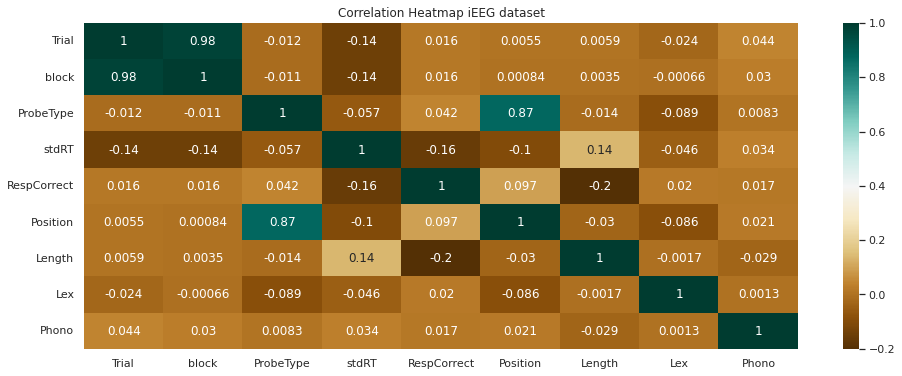

In [ ]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(ieeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


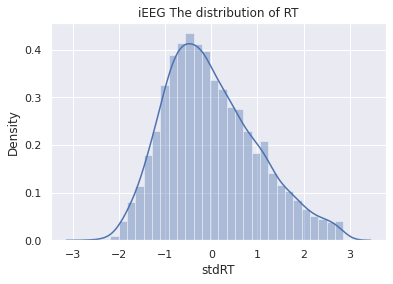

In [ ]:
sns.distplot(ieeg_data.stdRT)
pl.title('iEEG The distribution of RT');

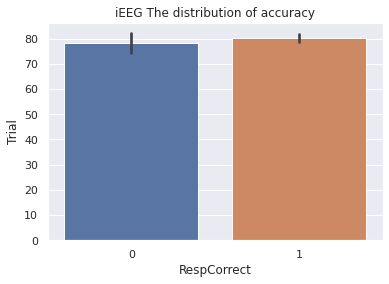

In [ ]:
sns.barplot(
    x = 'RespCorrect', y = 'Trial',
    data = ieeg_data
    )
pl.title('iEEG The distribution of accuracy');

**Models**

In [ ]:
model_fulli = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1138.745 	 AIC: 2277.491

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.114  0.337

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.993,0.940,1.046,0.027,1095.276,36.584,0.000,***
Lex,0.016,-0.007,0.039,0.012,3317.747,1.364,0.173,
Phono,0.008,-0.015,0.031,0.012,3330.449,0.683,0.494,
Length,-0.031,-0.036,-0.026,0.003,3318.097,-11.904,0.000,***
ProbeType,0.029,0.006,0.052,0.012,3330.187,2.436,0.015,*


In [ ]:
model_fulli1 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli1.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1146.399 	 AIC: 2292.797

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.937,0.808,1.066,0.066,3220.977,14.262,0.000,***
Lex,0.132,0.034,0.231,0.050,3319.531,2.639,0.008,**
Phono,-0.136,-0.235,-0.036,0.051,3315.895,-2.671,0.008,**
Length,-0.025,-0.043,-0.007,0.009,3313.369,-2.737,0.006,**
ProbeType,0.092,0.018,0.167,0.038,3314.711,2.435,0.015,*
Lex:Phono,0.041,-0.005,0.087,0.024,3319.061,1.736,0.083,.
Lex:Length,0.001,-0.009,0.011,0.005,3311.754,0.197,0.844,
Lex:ProbeType,-0.098,-0.144,-0.052,0.023,3322.411,-4.154,0.000,***
Phono:Length,0.008,-0.003,0.018,0.005,3320.582,1.436,0.151,
Phono:ProbeType,0.052,0.006,0.098,0.024,3312.736,2.210,0.027,*


In [ ]:
model_fulli2 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Phono*ProbeType + Phono*Length*ProbeType + Lex*Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli2.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Phono*ProbeType+Phono*Length*ProbeType+Lex*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1158.671 	 AIC: 2317.342

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.906,0.712,1.100,0.099,3322.168,9.143,0.000,***
Lex,0.091,-0.143,0.324,0.119,3309.188,0.761,0.447,
Phono,-0.025,-0.258,0.209,0.119,3313.236,-0.208,0.835,
Length,-0.021,-0.050,0.008,0.015,3310.479,-1.411,0.158,
ProbeType,0.113,-0.009,0.235,0.062,3310.329,1.819,0.069,.
Lex:Phono,0.016,-0.175,0.208,0.098,3312.332,0.167,0.867,
Lex:Length,0.010,-0.024,0.043,0.017,3308.996,0.556,0.578,
Lex:ProbeType,-0.069,-0.211,0.073,0.073,3308.994,-0.947,0.344,
Phono:Length,-0.009,-0.044,0.025,0.018,3311.312,-0.533,0.594,
Phono:ProbeType,-0.020,-0.160,0.121,0.072,3310.740,-0.275,0.783,


In [ ]:
model_fulli3 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Phono*ProbeType + Phono*Length*ProbeType + Lex*Length*ProbeType + Lex*Phono*Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli3.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Phono*ProbeType+Phono*Length*ProbeType+Lex*Length*ProbeType+Lex*Phono*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1161.270 	 AIC: 2322.539

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.864,0.645,1.083,0.112,3325.199,7.729,0.000,***
Lex,0.172,-0.132,0.476,0.155,3315.976,1.109,0.267,
Phono,0.054,-0.246,0.353,0.153,3319.287,0.351,0.725,
Length,-0.014,-0.048,0.019,0.017,3310.402,-0.824,0.410,
ProbeType,0.142,0.002,0.282,0.071,3311.578,1.987,0.047,*
Lex:Phono,-0.138,-0.552,0.277,0.212,3325.205,-0.650,0.516,
Lex:Length,-0.004,-0.050,0.043,0.024,3315.508,-0.160,0.873,
Lex:ProbeType,-0.124,-0.318,0.070,0.099,3317.569,-1.252,0.211,
Phono:Length,-0.022,-0.069,0.024,0.024,3317.296,-0.945,0.345,
Phono:ProbeType,-0.071,-0.259,0.116,0.096,3317.572,-0.748,0.455,


**Without match/mismatch**

In [ ]:
model_noprobe_i = Lmer(
    'RespCorrect ~ Lex + Phono + Length + (1|Subject)',
    data = ieeg_data
)
model_noprobe_i.fit()

Formula: RespCorrect~Lex+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1138.186 	 AIC: 2276.372

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.037,0.997,1.077,0.020,430.581,50.967,0.000,***
Lex,0.013,-0.009,0.036,0.012,3318.771,1.151,0.250,
Phono,0.008,-0.015,0.031,0.012,3331.334,0.708,0.479,
Length,-0.031,-0.036,-0.026,0.003,3319.051,-11.932,0.000,***


In [ ]:
model_noprobe_i1 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + (1|Subject)',
    data = ieeg_data
)
model_noprobe_i1.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1147.874 	 AIC: 2295.747

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.075,1.013,1.138,0.032,1640.731,33.648,0.000,***
Lex,-0.020,-0.090,0.051,0.036,3316.735,-0.547,0.585,
Phono,-0.048,-0.118,0.022,0.036,3323.988,-1.344,0.179,
Length,-0.036,-0.045,-0.027,0.005,3319.286,-7.706,0.000,***
Lex:Phono,0.032,-0.014,0.078,0.023,3322.626,1.350,0.177,
Lex:Length,0.003,-0.008,0.013,0.005,3315.803,0.508,0.611,
Phono:Length,0.007,-0.004,0.017,0.005,3323.930,1.278,0.201,


In [ ]:
model_noprobe_i2 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)',
    data = ieeg_data
)
model_noprobe_i2.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1151.512 	 AIC: 2303.023

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.075,1.003,1.146,0.037,2115.234,29.427,0.000,***
Lex,-0.019,-0.116,0.079,0.050,3315.848,-0.375,0.708,
Phono,-0.047,-0.140,0.047,0.048,3319.285,-0.983,0.326,
Length,-0.036,-0.047,-0.025,0.006,3316.597,-6.539,0.000,***
Lex:Phono,0.030,-0.102,0.161,0.067,3316.658,0.439,0.661,
Lex:Length,0.002,-0.013,0.017,0.008,3315.089,0.322,0.747,
Phono:Length,0.007,-0.008,0.021,0.007,3318.223,0.879,0.379,
Lex:Phono:Length,0.000,-0.020,0.021,0.010,3315.433,0.034,0.973,


**Model with Match vs. Mismatch**

In [ ]:
match_i = ieeg_data[ieeg_data['ProbeType'] == 2]
mismatch_i = ieeg_data[ieeg_data['ProbeType'] == 1]

In [ ]:
# model for MATCH
model_matchi = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)',
    data = match_i
)
model_matchi.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1575	 Groups: {'Subject': 22.0}

Log-likelihood: -442.880 	 AIC: 885.761

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.005  0.068
Residual               0.098  0.312

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.145,1.047,1.243,0.050,917.447,22.935,0.000,***
Lex,-0.056,-0.186,0.074,0.066,1551.072,-0.848,0.396,
Phono,-0.080,-0.201,0.040,0.062,1547.936,-1.303,0.193,
Length,-0.044,-0.058,-0.029,0.007,1546.379,-5.938,0.000,***
Lex:Phono,0.049,-0.132,0.229,0.092,1557.925,0.527,0.598,
Lex:Length,-0.000,-0.021,0.020,0.010,1550.400,-0.037,0.970,
Phono:Length,0.016,-0.003,0.035,0.010,1546.957,1.683,0.093,.
Lex:Phono:Length,-0.002,-0.030,0.026,0.014,1554.549,-0.137,0.891,


In [ ]:
# model for MISMATCH
model_mismatchi = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)',
    data = mismatch_i
)
model_mismatchi.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1768	 Groups: {'Subject': 22.0}

Log-likelihood: -690.641 	 AIC: 1381.281

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.050
Residual               0.123  0.351

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.998,0.894,1.101,0.053,1373.595,18.932,0.000,***
Lex,0.059,-0.082,0.200,0.072,1744.219,0.823,0.410,
Phono,-0.000,-0.141,0.140,0.072,1752.019,-0.006,0.995,
Length,-0.028,-0.043,-0.012,0.008,1743.511,-3.518,0.000,***
Lex:Phono,-0.046,-0.237,0.145,0.097,1750.809,-0.473,0.636,
Lex:Length,-0.002,-0.024,0.019,0.011,1743.642,-0.208,0.835,
Phono:Length,-0.005,-0.027,0.016,0.011,1750.360,-0.492,0.623,
Lex:Phono:Length,0.013,-0.017,0.042,0.015,1748.157,0.837,0.402,


**Model with Words vs. Non-words**

In [ ]:
words_i = ieeg_data[ieeg_data['Lex'] == 1]
nonwords_i = ieeg_data[ieeg_data['Lex'] == 0]

In [ ]:
model_wordsi = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + (1|Subject)',
    data = words_i
)
model_wordsi.fit()

Formula: RespCorrect~Phono+ProbeType+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1675	 Groups: {'Subject': 22.0}

Log-likelihood: -536.078 	 AIC: 1072.155

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.052
Residual               0.108  0.328

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.069,0.998,1.139,0.036,678.244,29.560,0.00,***
Phono,0.024,-0.008,0.055,0.016,1652.374,1.478,0.14,
ProbeType,-0.023,-0.055,0.009,0.016,1667.116,-1.407,0.16,
Length,-0.030,-0.037,-0.023,0.004,1650.681,-8.382,0.00,***


In [ ]:
model_nonwordsi = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + (1|Subject)',
    data = nonwords_i
)
model_nonwordsi.fit()

Formula: RespCorrect~Phono+ProbeType+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1668	 Groups: {'Subject': 22.0}

Log-likelihood: -598.277 	 AIC: 1196.553

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.117  0.343

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.937,0.865,1.010,0.037,1113.236,25.316,0.000,***
Phono,-0.013,-0.046,0.020,0.017,1662.917,-0.766,0.444,
ProbeType,0.077,0.044,0.110,0.017,1647.180,4.597,0.000,***
Length,-0.032,-0.040,-0.025,0.004,1644.197,-8.590,0.000,***


In [ ]:
model_wordsi1 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + (1|Subject)',
    data = words_i
)
model_wordsi1.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1675	 Groups: {'Subject': 22.0}

Log-likelihood: -543.525 	 AIC: 1087.049

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.052
Residual               0.108  0.328

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.048,0.885,1.210,0.083,1638.434,12.633,0.000,***
Phono,-0.099,-0.229,0.032,0.067,1648.830,-1.480,0.139,
ProbeType,0.012,-0.086,0.110,0.050,1648.990,0.243,0.808,
Length,-0.020,-0.043,0.004,0.012,1649.822,-1.664,0.096,.
Phono:ProbeType,0.052,-0.012,0.116,0.033,1654.854,1.584,0.113,
Phono:Length,0.008,-0.006,0.023,0.007,1653.450,1.157,0.247,
ProbeType:Length,-0.011,-0.025,0.004,0.007,1650.557,-1.468,0.142,


In [ ]:
model_nonwordsi1 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + (1|Subject)',
    data = nonwords_i
)
model_nonwordsi1.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1668	 Groups: {'Subject': 22.0}

Log-likelihood: -607.418 	 AIC: 1214.835

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.033
Residual               0.117  0.343

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.960,0.792,1.128,0.086,1657.786,11.197,0.000,***
Phono,-0.117,-0.256,0.022,0.071,1649.883,-1.653,0.099,.
ProbeType,0.076,-0.026,0.178,0.052,1641.534,1.458,0.145,
Length,-0.030,-0.055,-0.006,0.012,1641.567,-2.435,0.015,*
Phono:ProbeType,0.043,-0.023,0.109,0.034,1646.497,1.264,0.206,
Phono:Length,0.007,-0.008,0.021,0.008,1646.238,0.869,0.385,
ProbeType:Length,-0.004,-0.018,0.011,0.008,1643.009,-0.477,0.633,


In [ ]:
model_wordsi2 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + Phono*ProbeType*Length + (1|Subject)',
    data = words_i
)
model_wordsi2.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+Phono*ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1675	 Groups: {'Subject': 22.0}

Log-likelihood: -546.740 	 AIC: 1093.481

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.052
Residual               0.108  0.328

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.021,0.814,1.229,0.106,1662.022,9.643,0.000,***
Phono,-0.047,-0.328,0.233,0.143,1659.778,-0.332,0.740,
ProbeType,0.030,-0.101,0.162,0.067,1654.757,0.450,0.653,
Length,-0.015,-0.047,0.016,0.016,1654.607,-0.956,0.339,
Phono:ProbeType,0.016,-0.170,0.202,0.095,1663.565,0.169,0.866,
Phono:Length,-0.000,-0.043,0.043,0.022,1656.136,-0.002,0.998,
ProbeType:Length,-0.014,-0.034,0.007,0.010,1657.826,-1.317,0.188,
Phono:ProbeType:Length,0.006,-0.023,0.035,0.015,1660.467,0.404,0.686,


In [ ]:
model_nonwordsi2 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + ProbeType*Length*Phono + (1|Subject)',
    data = nonwords_i
)
model_nonwordsi2.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+ProbeType*Length*Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1668	 Groups: {'Subject': 22.0}

Log-likelihood: -609.664 	 AIC: 1219.327

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.117  0.342

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.853,0.630,1.076,0.114,1659.995,7.495,0.000,***
Phono,0.081,-0.224,0.386,0.156,1656.140,0.523,0.601,
ProbeType,0.149,0.006,0.291,0.073,1646.604,2.044,0.041,*
Length,-0.013,-0.047,0.021,0.017,1644.982,-0.733,0.464,
Phono:ProbeType,-0.088,-0.279,0.103,0.097,1654.219,-0.905,0.366,
Phono:Length,-0.026,-0.074,0.021,0.024,1653.910,-1.088,0.277,
ProbeType:Length,-0.015,-0.037,0.006,0.011,1643.360,-1.381,0.168,
Phono:ProbeType:Length,0.022,-0.008,0.051,0.015,1651.487,1.432,0.152,


**Model with H vs. L**

In [ ]:
high_i = ieeg_data[ieeg_data['Phono'] == 0]
low_i = ieeg_data[ieeg_data['Phono'] == 1]

In [ ]:
model_highi = Lmer(
    'RespCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Length*ProbeType + Length*Lex + Length*Lex*ProbeType + (1|Subject)',
    data = high_i
)
model_highi.fit()

Formula: RespCorrect~Lex+ProbeType+Length+Lex*ProbeType+Length*ProbeType+Length*Lex+Length*Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1545	 Groups: {'Subject': 22.0}

Log-likelihood: -562.410 	 AIC: 1124.820

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.043
Residual               0.116  0.341

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.866,0.644,1.089,0.114,1536.739,7.632,0.000,***
Lex,0.167,-0.141,0.476,0.158,1527.161,1.063,0.288,
ProbeType,0.141,-0.001,0.282,0.072,1521.881,1.942,0.052,.
Length,-0.014,-0.048,0.020,0.017,1520.551,-0.827,0.408,
Lex:ProbeType,-0.121,-0.318,0.076,0.101,1528.978,-1.204,0.229,
ProbeType:Length,-0.015,-0.036,0.007,0.011,1519.204,-1.309,0.191,
Lex:Length,-0.003,-0.051,0.044,0.024,1526.797,-0.137,0.891,
Lex:ProbeType:Length,0.003,-0.028,0.033,0.016,1528.330,0.179,0.858,


In [ ]:
model_lowi = Lmer(
    'RespCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Length*ProbeType + Length*Lex + Length*Lex*ProbeType + (1|Subject)',
    data = low_i
)
model_lowi.fit()

Formula: RespCorrect~Lex+ProbeType+Length+Lex*ProbeType+Length*ProbeType+Length*Lex+Length*Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1798	 Groups: {'Subject': 22.0}

Log-likelihood: -600.396 	 AIC: 1200.791

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.024
Residual               0.111  0.333

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.926,0.724,1.128,0.103,1789.480,8.987,0.000,***
Lex,0.020,-0.258,0.297,0.142,1789.923,0.139,0.890,
ProbeType,0.065,-0.057,0.188,0.063,1783.102,1.044,0.297,
Length,-0.038,-0.070,-0.006,0.016,1784.013,-2.335,0.020,*
Lex:ProbeType,0.003,-0.178,0.183,0.092,1789.652,0.029,0.977,
ProbeType:Length,0.005,-0.014,0.025,0.010,1782.905,0.554,0.580,
Lex:Length,0.025,-0.019,0.069,0.022,1786.272,1.112,0.266,
Lex:ProbeType:Length,-0.016,-0.044,0.013,0.014,1787.854,-1.078,0.281,


(0.775, 0.975)

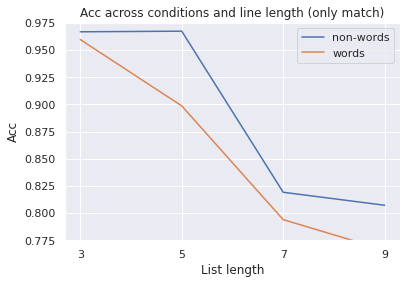

(0.775, 0.975)

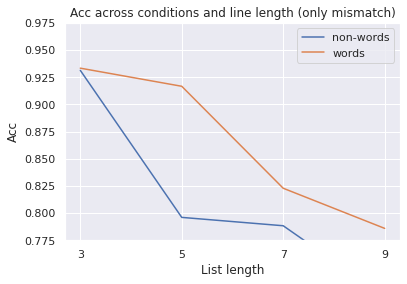

In [ ]:
pl.figure()
subset = ieeg_short[ieeg_short['ProbeType'] == 1] # mismatch
subset = subset.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.RespCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across conditions and line length (only mismatch)');
pl.ylim([0.775, 0.975])

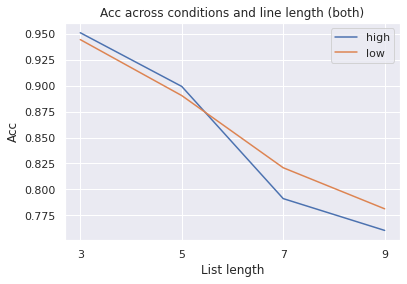

In [ ]:
pl.figure()
subset = ieeg_short.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'high')
  elif i == 1:
      pl.plot(x.Length, x.RespCorrect, label = 'low')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across conditions and line length (both)');

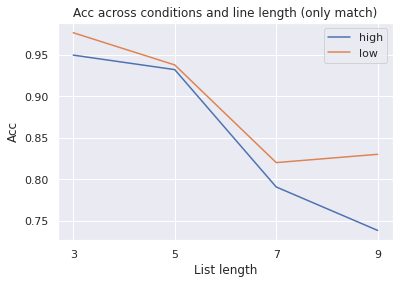

In [ ]:
pl.figure()
match = ieeg_short[ieeg_short['ProbeType'] == 2] # match
subset = match.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'high')
  elif i == 1:
      pl.plot(x.Length, x.RespCorrect, label = 'low')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across conditions and line length (only match)');

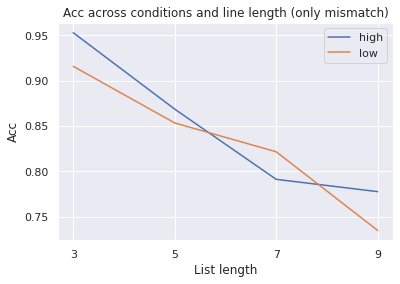

In [ ]:
pl.figure()
mismatch = ieeg_short[ieeg_short['ProbeType'] == 1] # mismatch
subset = mismatch.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'high')
  elif i == 1:
    pl.plot(x.Length, x.RespCorrect, label = 'low')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across conditions and line length (only mismatch)');

In [ ]:
pl.figure()
pl.plo

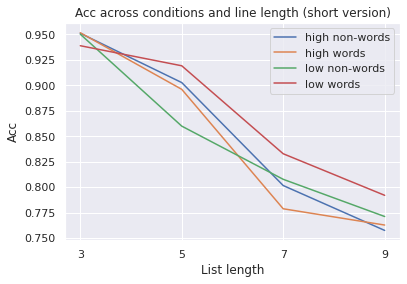

In [ ]:
pl.figure()
subset = ieeg_short.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length (short version)');

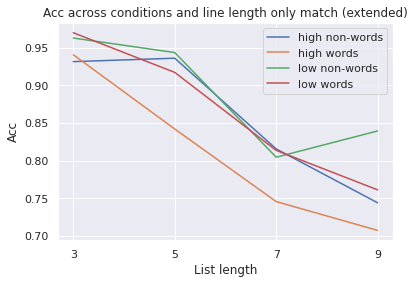

In [ ]:
# WHEN MATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = match_.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only match (extended)');

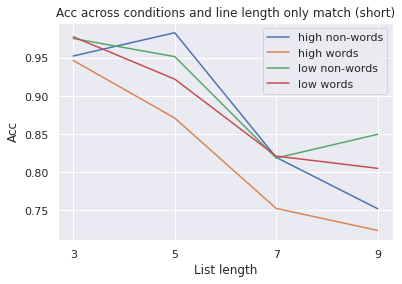

In [ ]:
# WHEN MATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = match_short.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only match (short)');

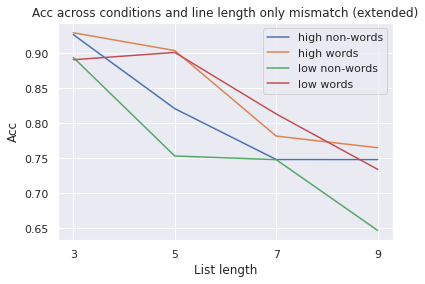

In [ ]:
# WHEN MISMATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = mismatch_.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only mismatch (extended)');

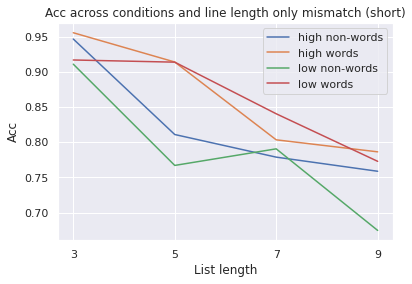

In [ ]:
# WHEN MISMATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = mismatch_short.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only mismatch (short)');

## Modeling updated iEEG dataset

In [ ]:
ieeg_short.head()

,Trial,block,ProbeType,probeSound_idx,StimlusCategory,ReactionTime,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,Position,Length,stdRT,Lex,Phono,Subject
0,0,1,2,29,Low Words,0.857518,1,Responded,low words,"[29, 25, 30]",1,3,-0.896086,1,1,D23
1,1,1,2,5,High Words,1.339604,1,Responded,high words,"[2, 5, 8, 4, 7, 10, 3]",1,7,0.574265,1,0,D23
2,2,1,2,16,High Non-Words,1.045657,1,Responded,high non-words,"[19, 14, 18, 16, 20, 15, 17]",2,7,-0.322269,0,0,D23
3,3,1,1,29,High Words,1.497001,1,Responded,low words,"[10, 2, 7, 9, 1, 8, 6, 5, 4]",0,9,1.054321,1,1,D23
4,4,1,1,9,Low Words,1.679783,1,Responded,high words,"[30, 24, 25, 29, 21]",0,5,1.611803,1,0,D23


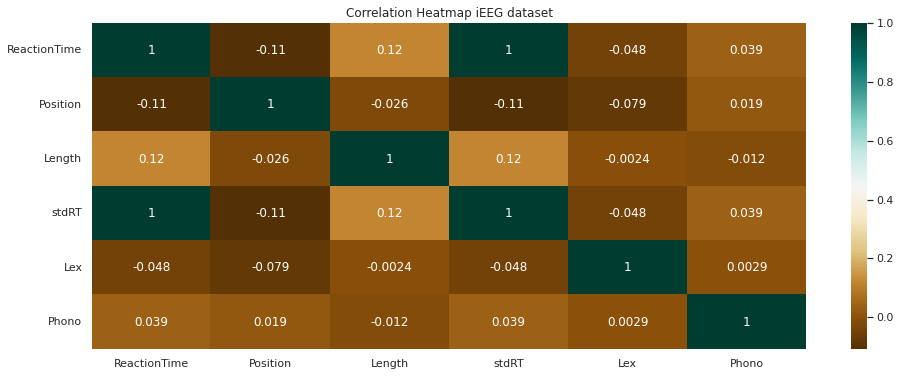

In [ ]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(ieeg_short.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


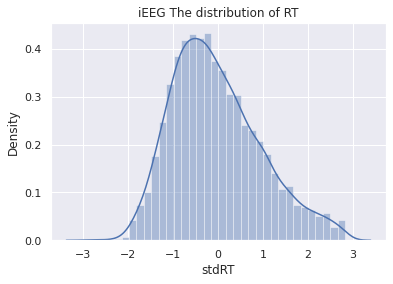

In [ ]:
sns.distplot(ieeg_short.stdRT)
pl.title('iEEG The distribution of RT');

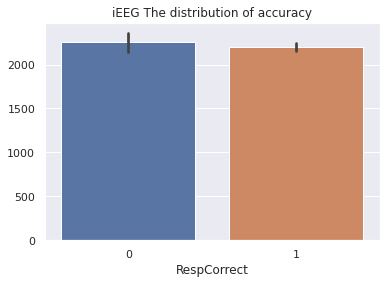

In [ ]:
sns.barplot(
    x = ieeg_short.RespCorrect,
    y = ieeg_short.index
)
pl.title('iEEG The distribution of accuracy');

In [ ]:
ieeg_short.RespCorrect = ieeg_short.RespCorrect.astype('int64')
ieeg_short.ProbeType = ieeg_short.ProbeType.astype('int64')
ieeg_short.Trial = ieeg_short.Trial.astype('int64')

In [ ]:
ieeg_sh = ieeg_short[[
                      'Trial', 'Subject', 'block', 'ProbeType',
                      'stdRT', 'RespCorrect', 'Position',
                      'Length', 'Lex', 'Phono'
]]

**Full model**

In [ ]:
model_main = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 4038	 Groups: {'Subject': 27.0}

Log-likelihood: -1435.942 	 AIC: 2871.883

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.041
Residual               0.117  0.343

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.978,0.929,1.028,0.025,1010.206,38.782,0.000,***
Phono,0.009,-0.013,0.030,0.011,4023.839,0.800,0.424,
Lex,0.013,-0.008,0.034,0.011,4007.533,1.180,0.238,
Length,-0.031,-0.036,-0.026,0.002,4008.353,-12.770,0.000,***
ProbeType,0.034,0.012,0.055,0.011,4022.439,3.091,0.002,**


In [ ]:
model_main1 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + Phono*Lex + Phono*Length + Phono*ProbeType + Lex*Length + Lex*ProbeType + Length*ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main1.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+Phono*Lex+Phono*Length+Phono*ProbeType+Lex*Length+Lex*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 4038	 Groups: {'Subject': 27.0}

Log-likelihood: -1442.811 	 AIC: 2885.623

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.042
Residual               0.117  0.341

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.951,0.833,1.069,0.060,3784.837,15.787,0.000,***
Phono,-0.137,-0.228,-0.046,0.047,4008.926,-2.940,0.003,**
Lex,0.133,0.043,0.224,0.046,4016.005,2.892,0.004,**
Length,-0.029,-0.046,-0.012,0.009,4005.302,-3.421,0.001,***
ProbeType,0.074,0.006,0.142,0.035,4006.587,2.129,0.033,*
Phono:Lex,0.035,-0.008,0.077,0.022,4009.904,1.613,0.107,
Phono:Length,0.007,-0.002,0.017,0.005,4012.574,1.455,0.146,
Phono:ProbeType,0.057,0.015,0.100,0.022,4002.695,2.633,0.008,**
Lex:Length,0.000,-0.009,0.010,0.005,4001.414,0.099,0.921,
Lex:ProbeType,-0.095,-0.138,-0.053,0.022,4021.608,-4.394,0.000,***


In [ ]:
model_main2 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + Phono*Lex + Phono*Length + Phono*ProbeType + Lex*Length + Lex*ProbeType + Length*ProbeType + Phono*Lex*Length + Phono*Lex*ProbeType + Phono*Length*ProbeType + Length*Lex*ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main2.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+Phono*Lex+Phono*Length+Phono*ProbeType+Lex*Length+Lex*ProbeType+Length*ProbeType+Phono*Lex*Length+Phono*Lex*ProbeType+Phono*Length*ProbeType+Length*Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1441.279 	 AIC: 2882.558

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.119  0.345

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.928,0.745,1.112,0.094,3856.936,9.927,0.000,***
Phono,-0.044,-0.265,0.178,0.113,3848.855,-0.388,0.698,
Lex,0.072,-0.148,0.292,0.112,3842.474,0.640,0.522,
Length,-0.026,-0.054,0.002,0.014,3844.513,-1.817,0.069,.
ProbeType,0.086,-0.029,0.202,0.059,3844.205,1.469,0.142,
Phono:Lex,0.025,-0.156,0.207,0.093,3845.880,0.272,0.785,
Phono:Length,-0.011,-0.043,0.022,0.017,3847.328,-0.628,0.530,
Phono:ProbeType,0.002,-0.132,0.136,0.068,3844.525,0.029,0.977,
Lex:Length,0.011,-0.021,0.043,0.016,3843.010,0.669,0.504,
Lex:ProbeType,-0.047,-0.181,0.088,0.069,3842.848,-0.679,0.497,


In [ ]:
ieeg_sh

In [ ]:
model_main3 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + Phono*Lex + Phono*Length + Phono*ProbeType + Lex*Length + Lex*ProbeType + Length*ProbeType + Phono*Lex*Length + Phono*Length*ProbeType + Phono*Lex*ProbeType + Length*Lex*ProbeType + Phono*Lex*Length*ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main3.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+Phono*Lex+Phono*Length+Phono*ProbeType+Lex*Length+Lex*ProbeType+Length*ProbeType+Phono*Lex*Length+Phono*Length*ProbeType+Phono*Lex*ProbeType+Length*Lex*ProbeType+Phono*Lex*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1444.155 	 AIC: 2888.310

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.119  0.345

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.905,0.699,1.112,0.106,3862.215,8.577,0.000,***
Phono,-0.001,-0.286,0.283,0.145,3854.139,-0.008,0.994,
Lex,0.116,-0.171,0.403,0.147,3850.276,0.791,0.429,
Length,-0.022,-0.054,0.010,0.016,3845.105,-1.348,0.178,
ProbeType,0.102,-0.031,0.234,0.068,3845.693,1.509,0.131,
Phono:Lex,-0.058,-0.452,0.336,0.201,3861.161,-0.289,0.772,
Phono:Length,-0.018,-0.062,0.027,0.023,3852.295,-0.779,0.436,
Phono:ProbeType,-0.026,-0.205,0.152,0.091,3851.973,-0.288,0.773,
Lex:Length,0.004,-0.041,0.048,0.023,3850.858,0.165,0.869,
Lex:ProbeType,-0.076,-0.260,0.107,0.094,3852.279,-0.815,0.415,


**Without match/mismatch**

In [ ]:
model_noprobe = Lmer(
    'RespCorrect ~ Phono + Lex + Length + (1|Subject)',
    data = ieeg_sh
)
model_noprobe.fit()

Formula: RespCorrect~Phono+Lex+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1424.260 	 AIC: 2848.520

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.031,0.993,1.070,0.019,458.699,53.048,0.000,***
Phono,0.008,-0.014,0.030,0.011,3869.833,0.749,0.454,
Lex,0.010,-0.012,0.032,0.011,3852.468,0.877,0.380,
Length,-0.032,-0.037,-0.027,0.002,3853.421,-12.733,0.000,***


In [ ]:
model_noprobe1 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + Phono*Lex + Lex*Length + Phono*Length + (1|Subject)',
    data = ieeg_sh
)
model_noprobe1.fit()

Formula: RespCorrect~Phono+Lex+Length+Phono*Lex+Lex*Length+Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1434.460 	 AIC: 2868.919

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.062,1.002,1.121,0.030,1777.286,34.999,0.000,***
Phono,-0.042,-0.108,0.025,0.034,3862.114,-1.226,0.220,
Lex,-0.011,-0.079,0.056,0.034,3850.316,-0.334,0.739,
Length,-0.036,-0.044,-0.027,0.004,3854.924,-7.956,0.000,***
Phono:Lex,0.026,-0.018,0.070,0.022,3857.134,1.159,0.246,
Lex:Length,0.001,-0.009,0.011,0.005,3849.525,0.243,0.808,
Phono:Length,0.006,-0.004,0.016,0.005,3861.781,1.234,0.217,


In [ ]:
model_noprobe2 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + Phono*Lex + Lex*Length + Phono*Length + Phono*Lex*Length + (1|Subject)',
    data = ieeg_sh
)
model_noprobe2.fit()

Formula: RespCorrect~Phono+Lex+Length+Phono*Lex+Lex*Length+Phono*Length+Phono*Lex*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1438.100 	 AIC: 2876.201

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.057,0.989,1.125,0.035,2328.100,30.480,0.000,***
Phono,-0.032,-0.122,0.057,0.046,3859.036,-0.714,0.475,
Lex,-0.002,-0.094,0.090,0.047,3850.125,-0.037,0.971,
Length,-0.035,-0.045,-0.024,0.005,3853.562,-6.602,0.000,***
Phono:Lex,0.008,-0.118,0.133,0.064,3852.169,0.121,0.904,
Lex:Length,-0.000,-0.015,0.014,0.007,3849.735,-0.054,0.957,
Phono:Length,0.005,-0.009,0.019,0.007,3857.332,0.654,0.513,
Phono:Lex:Length,0.003,-0.017,0.023,0.010,3850.998,0.303,0.762,


**Words vs. Non-words**

In [ ]:
words_ieeg = ieeg_sh[ieeg_sh['Lex'] == 1]
nonwords_ieeg = ieeg_sh[ieeg_sh['Lex'] == 0]

In [ ]:
model_words_ieeg = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + (1|Subject)',
    data = words_ieeg
)
model_words_ieeg.fit()

Formula: RespCorrect~Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1943	 Groups: {'Subject': 26.0}

Log-likelihood: -684.055 	 AIC: 1368.111

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.057
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.059,0.991,1.127,0.035,735.395,30.644,0.000,***
Phono,0.021,-0.009,0.052,0.015,1917.777,1.375,0.169,
Length,-0.031,-0.038,-0.025,0.003,1914.643,-9.112,0.000,***
ProbeType,-0.019,-0.050,0.012,0.016,1936.348,-1.209,0.227,


In [ ]:
model_nonwords_ieeg = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + (1|Subject)',
    data = nonwords_ieeg
)
model_nonwords_ieeg.fit()

Formula: RespCorrect~Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1938	 Groups: {'Subject': 26.0}

Log-likelihood: -734.341 	 AIC: 1468.682

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.123  0.350

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.914,0.846,0.983,0.035,1385.438,26.262,0.000,***
Phono,-0.010,-0.042,0.021,0.016,1933.975,-0.642,0.521,
Length,-0.032,-0.039,-0.025,0.004,1911.127,-8.950,0.000,***
ProbeType,0.085,0.053,0.116,0.016,1920.102,5.312,0.000,***


In [ ]:
model_words_ieeg1 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)',
    data = words_ieeg
)
model_words_ieeg1.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1943	 Groups: {'Subject': 26.0}

Log-likelihood: -691.498 	 AIC: 1382.996

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.048,0.893,1.203,0.079,1893.692,13.256,0.000,***
Phono,-0.104,-0.228,0.020,0.063,1914.297,-1.639,0.101,
Length,-0.023,-0.045,-0.000,0.011,1915.922,-1.988,0.047,*
ProbeType,0.009,-0.084,0.102,0.048,1914.629,0.189,0.850,
Phono:Length,0.009,-0.005,0.022,0.007,1918.038,1.246,0.213,
Phono:ProbeType,0.052,-0.009,0.114,0.031,1920.044,1.669,0.095,.
Length:ProbeType,-0.010,-0.023,0.004,0.007,1916.559,-1.368,0.172,


In [ ]:
model_nonwords_ieeg1 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)',
    data = nonwords_ieeg
)
model_nonwords_ieeg1.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1938	 Groups: {'Subject': 26.0}

Log-likelihood: -742.846 	 AIC: 1485.692

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.123  0.350

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.978,0.820,1.136,0.080,1929.447,12.151,0.000,***
Phono,-0.131,-0.263,0.000,0.067,1921.011,-1.953,0.051,.
Length,-0.034,-0.057,-0.011,0.012,1909.123,-2.902,0.004,**
ProbeType,0.052,-0.044,0.148,0.049,1908.820,1.056,0.291,
Phono:Length,0.005,-0.010,0.019,0.007,1921.560,0.633,0.527,
Phono:ProbeType,0.062,-0.001,0.125,0.032,1914.186,1.936,0.053,.
Length:ProbeType,-0.000,-0.014,0.014,0.007,1910.547,-0.005,0.996,


In [ ]:
model_words_ieeg2 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + ProbeType*Length*Phono + (1|Subject)',
    data = words_ieeg
)
model_words_ieeg2.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+ProbeType*Length*Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1943	 Groups: {'Subject': 26.0}

Log-likelihood: -694.611 	 AIC: 1389.223

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.006,0.808,1.203,0.101,1926.777,9.979,0.000,***
Phono,-0.021,-0.289,0.246,0.137,1925.801,-0.155,0.877,
Length,-0.016,-0.046,0.015,0.015,1920.836,-1.014,0.311,
ProbeType,0.038,-0.087,0.163,0.064,1920.339,0.594,0.553,
Phono:Length,-0.005,-0.047,0.037,0.021,1921.109,-0.237,0.812,
Phono:ProbeType,-0.006,-0.183,0.171,0.090,1929.686,-0.062,0.951,
Length:ProbeType,-0.014,-0.034,0.005,0.010,1923.949,-1.447,0.148,
Phono:Length:ProbeType,0.010,-0.018,0.037,0.014,1925.598,0.682,0.495,


In [ ]:
model_nonwords_ieeg2 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + ProbeType*Length*Phono + (1|Subject)',
    data = nonwords_ieeg
)
model_nonwords_ieeg2.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+ProbeType*Length*Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1938	 Groups: {'Subject': 26.0}

Log-likelihood: -745.447 	 AIC: 1490.893

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.122  0.350

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.893,0.684,1.103,0.107,1929.931,8.359,0.000,***
Phono,0.026,-0.262,0.314,0.147,1926.240,0.177,0.860,
Length,-0.020,-0.053,0.012,0.017,1913.759,-1.225,0.221,
ProbeType,0.109,-0.025,0.243,0.068,1914.862,1.595,0.111,
Phono:Length,-0.022,-0.066,0.023,0.023,1924.149,-0.942,0.346,
Phono:ProbeType,-0.042,-0.223,0.139,0.092,1923.726,-0.456,0.648,
Length:ProbeType,-0.010,-0.030,0.011,0.011,1911.326,-0.893,0.372,
Phono:Length:ProbeType,0.017,-0.011,0.045,0.014,1920.794,1.202,0.230,


## Investigation

In [ ]:
# wanna check is there any difference depending on the part of experiment
# beginning of the experiment vs. the end 

**EEG dataset**

In [ ]:
trial_category = []
for i in eeg_data.Subject.unique():
  subset = eeg_data[eeg_data['Subject'] == i]
  for i in range(0, subset.shape[0]):
    if i < 63:
      trial_category.append('beginning')
    elif 63 <= i <= 126:
      trial_category.append('middle')
    elif 126 < i <= 191:
      trial_category.append('end')

In [ ]:
eeg_data['TrialPos'] = trial_category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


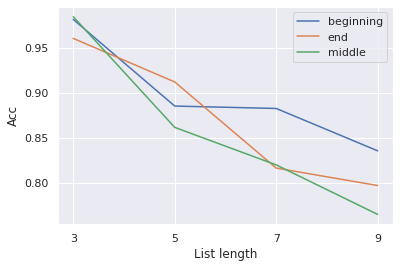

In [ ]:
pl.figure()
subset = eeg_data.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

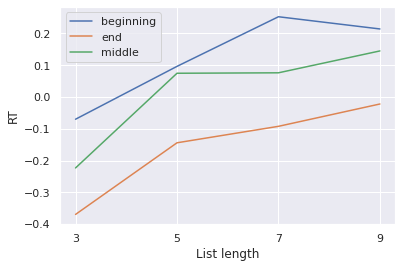

In [ ]:
pl.figure()
subset = eeg_data.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.TrialPos.unique());

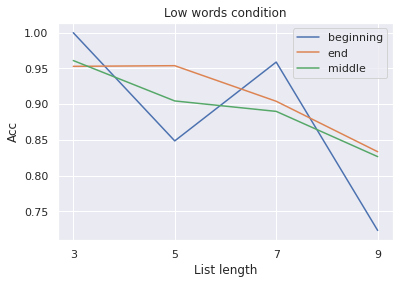

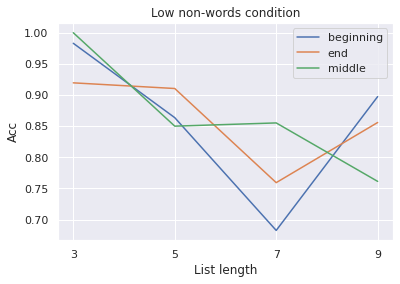

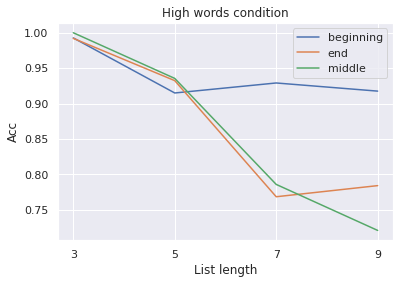

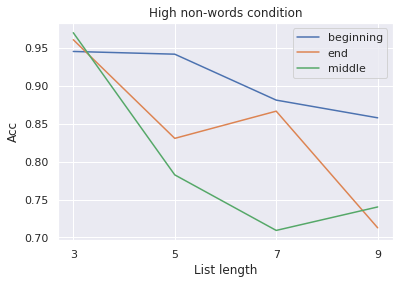

In [ ]:
# Accuracy
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

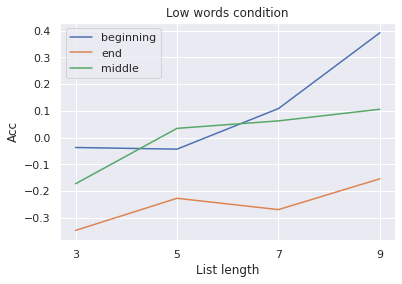

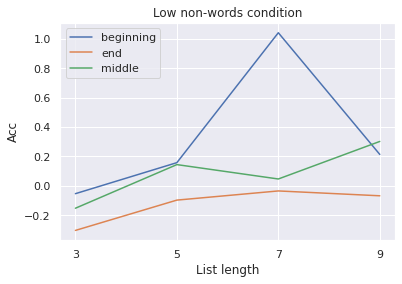

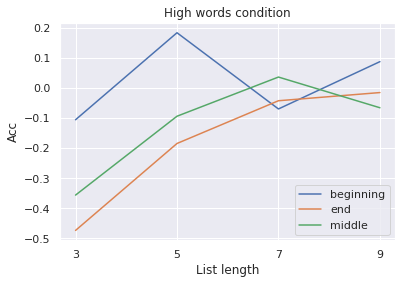

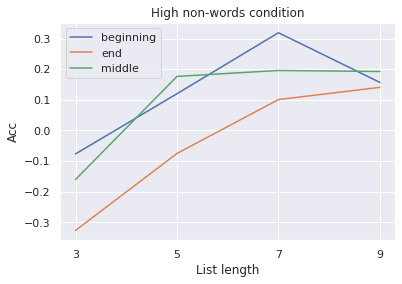

In [ ]:
# Reaction Time 
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

In [ ]:
new = []
check = eeg_data.TrialPos.values
for i in range(0, len(check)):
  if check[i] == 'beginning':
    new.append(0)
  elif check[i] == 'middle':
    new.append(1)
  elif check[i] == 'end':
    new.append(2)
  else:
    print('Check')

In [ ]:
eeg_data['TrialP'] = new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_trialpos = Lmer(
    'ResponseCorrect ~ Lex + Length + TrialP + ProbeType + Phono + (1|Subject)',
    data = eeg_data
)
model_trialpos.fit()

Formula: ResponseCorrect~Lex+Length+TrialP+ProbeType+Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1549.434 	 AIC: 3098.867

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.103  0.321

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.973,0.932,1.014,0.021,984.435,46.304,0.000,***
Lex,0.031,0.014,0.048,0.009,5300.607,3.505,0.000,***
Length,-0.028,-0.032,-0.024,0.002,5300.455,-14.418,0.000,***
TrialP,-0.013,-0.024,-0.003,0.005,5310.982,-2.467,0.014,*
ProbeType,0.046,0.029,0.063,0.009,5306.918,5.198,0.000,***
Phono,-0.000,-0.017,0.017,0.009,5301.145,-0.003,0.998,


**iEEG dataset**

In [ ]:
ieeg_sh.head()

,Trial,Subject,block,ProbeType,stdRT,RespCorrect,Position,Length,Lex,Phono
0,0,D23,1,2,-0.896484,1,1,3,1,1
1,1,D23,1,2,0.564665,1,1,7,1,0
2,2,D23,1,2,-0.326257,1,2,7,0,0
3,3,D23,1,1,1.041717,1,0,9,1,1
4,4,D23,1,1,1.595710,1,0,5,1,0


In [ ]:
trial_category = []
for i in ieeg_sh.Subject.unique():
  subset = ieeg_sh[ieeg_sh['Subject'] == i]
  for i in range(0, subset.shape[0]):
    if i < 63:
      trial_category.append('beginning')
    elif 63 <= i <= 126:
      trial_category.append('middle')
    elif 126 < i <= 191:
      trial_category.append('end')

In [ ]:
ieeg_sh['TrialPos'] = trial_category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


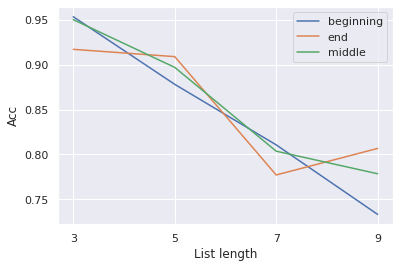

In [ ]:
pl.figure()
subset = ieeg_sh.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

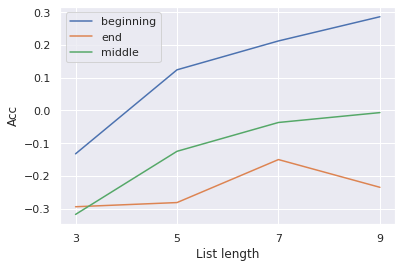

In [ ]:
pl.figure()
subset = ieeg_sh.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

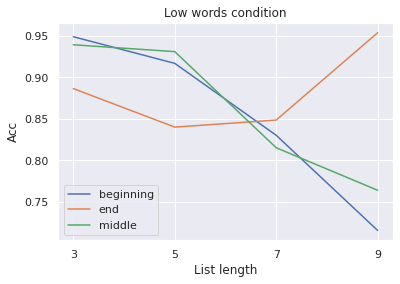

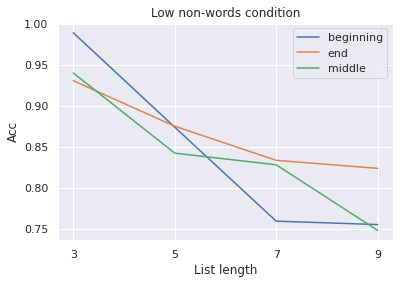

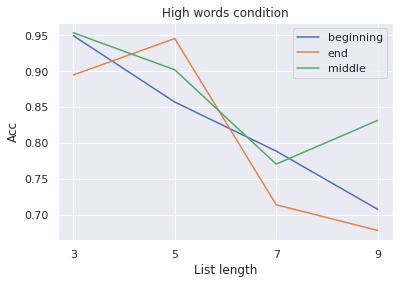

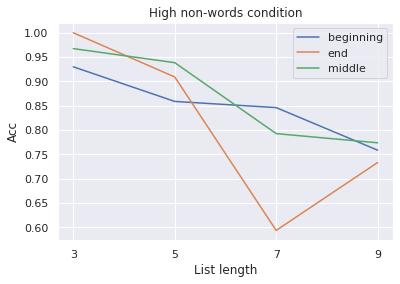

In [ ]:
# Accuracy
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

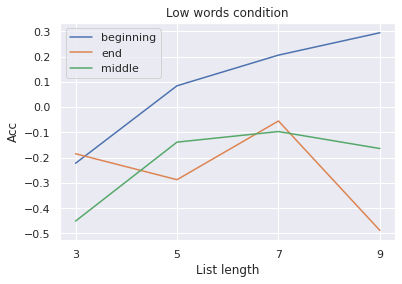

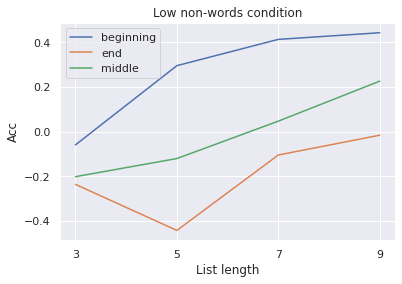

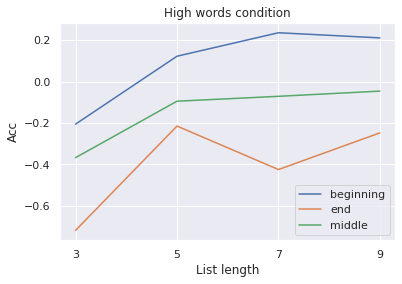

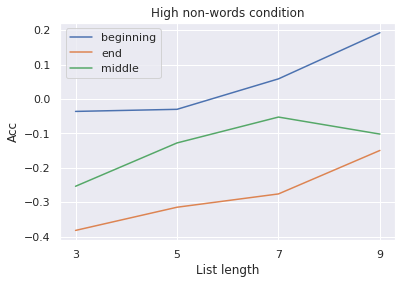

In [ ]:
# Reaction Time 
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

In [ ]:
ieeg_sh.head()

,Trial,Subject,block,ProbeType,stdRT,RespCorrect,Position,Length,Lex,Phono,TrialPos,TrialP
0,0,D23,1,2,-0.896484,1,1,3,1,1,beginning,0
1,1,D23,1,2,0.564665,1,1,7,1,0,beginning,0
2,2,D23,1,2,-0.326257,1,2,7,0,0,beginning,0
3,3,D23,1,1,1.041717,1,0,9,1,1,beginning,0
4,4,D23,1,1,1.595710,1,0,5,1,0,beginning,0


In [ ]:
new = []
check = ieeg_sh.TrialPos.values
for i in range(0, len(check)):
  if check[i] == 'beginning':
    new.append(0)
  elif check[i] == 'middle':
    new.append(1)
  elif check[i] == 'end':
    new.append(2)
  else:
    print('Check')

In [ ]:
ieeg_sh['TrialP'] = new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_trialpos_i = Lmer(
    'RespCorrect ~ Lex + Length + Phono + ProbeType + TrialP + (1|Subject)',
    data = ieeg_sh
)
model_trialpos_i.fit()

Formula: RespCorrect~Lex+Length+Phono+ProbeType+TrialP+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3725	 Groups: {'Subject': 25.0}

Log-likelihood: -1372.663 	 AIC: 2745.326

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.980,0.927,1.033,0.027,1159.776,36.307,0.000,***
Lex,0.011,-0.011,0.033,0.011,3695.580,0.959,0.338,
Length,-0.032,-0.037,-0.027,0.003,3696.417,-12.518,0.000,***
Phono,0.008,-0.014,0.030,0.011,3712.172,0.700,0.484,
ProbeType,0.033,0.010,0.055,0.011,3707.061,2.855,0.004,**
TrialP,0.005,-0.011,0.020,0.008,3719.000,0.586,0.558,
